# Chapter 13 - Tectonic-scale models and modelling tools

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import scipy.sparse as sp
from scipy.sparse.linalg import spsolve
from scipy.optimize import fsolve, brentq
from scipy.special import lambertw, erf
from scipy.integrate import odeint, quad, cumtrapz
from scipy.interpolate import interp1d

import warnings
warnings.filterwarnings('ignore')

## Corner-flow with magmatic segregation

This simplified problem is governed by the system

$$
\begin{align}
    \label{eq:cornerflow-twophase-stokes}
    \Grad\pres = \delsq\vel \\
    \Div\vel = 0
\end{align}
$$

and

$$
\begin{equation*}
  \vel\liq = \vel - \frac{1}{\velratio}\left(\Grad\pres + \unit{\gravity}\right)
\end{equation*}
$$

The nondimensional solution to $\eqref{eq:cornerflow-twophase-stokes}$ is

$$
\begin{align}
    f(\theta) &= A\sin\theta -B\theta\cos\theta, \\
    \vel &= \left[f'(\theta)\rhat - f(\theta)\thetahat\right], \label{eq:cornerflow-solid-velocity} \\
    \pres &= -\frac{1}{r}\left[f'''(\theta) + f'(\theta)\right] = -\frac{2B}{r}\cos\theta,
\end{align}
$$

where

$$
\begin{equation*}
  A = \frac{2\sin^2\theta_p}{\pi - 2\theta_p-\sin2\theta_2}
  \text{ and }
  B = \frac{2}{\pi - 2\theta_p-\sin2\theta_2}.
\end{equation*}
$$

Recall that $\theta_p$ is the angle beneath the horizontal made by the base of the rigid wedge that represents the lithosphere.  Using the cylindrical coordinate system,

$$
\begin{align}
  \unit{\gravity} &= \cos\theta\rhat - \sin\theta\thetahat,\\
  \Grad\pres &= \pdiff{\pres}{r}\rhat + \frac{1}{r}\pdiff{\pres}{\theta}\thetahat.
\end{align}
$$

The liquid velocity is then

$$
\begin{equation}
  \label{eq:cornerflow-liquid-velocity}
  \vel\liq = \left(f'(\theta)\rhat - f(\theta)\thetahat\right) -
  \frac{1}{\velratio}\left\{\frac{1}{r^2}\left[\left(f''' +f'\right)\rhat - \left(f'''' + f''\right)\thetahat\right] + \cos\theta\rhat + \sin\theta\thetahat\right\}.
\end{equation}
$$

The radial and tangential components of the solid and liquid velocities are implemented as:

In [2]:
def vel_solid_radial(alph, theta):

    return -(
        2.*np.sin(alph)**2 * np.cos(theta) - 2.*np.cos(theta) 
        + 2.*theta*np.sin(theta))/(2.*alph - np.pi + np.sin(2.*alph)
    )

def vel_solid_tangential(alph, theta):

    return (
        2.*np.sin(alph)**2 * np.sin(theta) - 2.*theta*np.cos(theta)
    )/(
        2.*alph - np.pi + np.sin(2.*alph)
    )

def vel_liquid_radial(alph, theta, r, e):
    sin_a = np.sin(alph)
    sin_t = np.sin(theta)
    cos_t = np.cos(theta)
    numer = 2.*sin_a**2 * cos_t - 2.*cos_t + 2.*theta*sin_t
    denom = 2.*alph - np.pi + np.sin(2.*alph)
    return -numer/denom - (
        cos_t - (
            numer/denom - (2.*sin_a**2 * cos_t - 6.*cos_t + 2.*theta*sin_t)/denom
        )/r**2
    )/e

def vel_liquid_tangential(alph, theta, r, e):
    sin_t = np.sin(theta)
    sin_a = np.sin(alph)
    cos_t = np.cos(theta)
    numer = -2.*sin_a**2 * sin_t + 2.*theta*cos_t
    denom = 2.*alph - np.pi + np.sin(2.*alph)
    return (sin_t - (
            (4.*sin_t + numer)/denom - (8.*sin_t + numer)/denom
        )/r**2
    )/e - numer/denom

Figure 13.1 below plot the streamlines of the solid $\eqref{eq:cornerflow-solid-velocity}$ and liquid $\eqref{eq:cornerflow-liquid-velocity}$ velocities for the corner flow solution with uniform viscosity and porosity. The domain has a fixed size in dimensional units. The top row of panels has a larger lithospheric wedge angle $(\theta_p=30^\circ)$ than the bottom row $(\theta_p=15^\circ)$.  The left column has 100$\times$ slower melt segregation ($\velratio=1$) than the right column ($\velratio=0.01$).

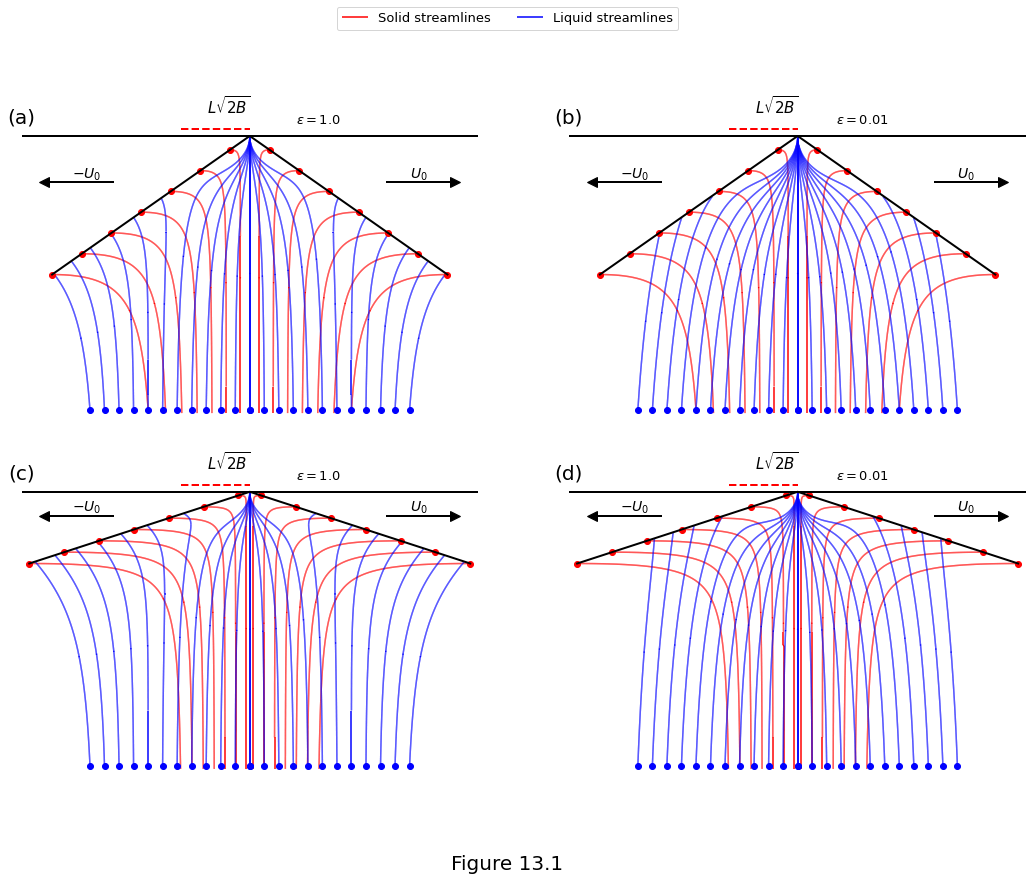

In [3]:
f, ax = plt.subplots(2, 2)
f.set_size_inches(15.0, 12.0)

Ny = 500
aspect = 2.0
Nx = int(np.round(Ny*aspect))
x = np.linspace(-0.5*aspect, 0.5*aspect, Nx)
y = np.linspace(0.0, 1.0, Ny)
X, Y = np.meshgrid(x, y)
theta = -np.arctan2(Y, X) + 0.5*np.pi

seedVS = np.zeros([7, 2])
seedVL = np.zeros([12, 2])

L = 0.2
evec = np.asarray([1, 0.01])
alphvec = np.asarray([30*np.pi/180., 15*np.pi/180.])
r = np.sqrt(X**2 + Y**2)/L

annotations = [['(a)', '(b)'], ['(c)', '(d)']]

plots = []

for i, alph in enumerate(alphvec):
    B = 2./(np.pi - 2*alph - np.sin(2.*alph))
    inplates = np.fabs(theta) > (0.5 * np.pi - alph)
    Lf = L * np.sqrt(2*B)
    for j, e in enumerate(evec):
        VSR = vel_solid_radial(alph, theta)
        VST = vel_solid_tangential(alph, theta)
        VLR = vel_liquid_radial(alph, theta, r, e)
        VLT = vel_liquid_tangential(alph, theta, r, e)
        VSX = VSR * np.sin(theta) + VST * np.cos(theta)
        VSY = VSR * np.cos(theta) - VST * np.sin(theta)
        VLX = VLR * np.sin(theta) + VLT * np.cos(theta)
        VLY = VLR * np.cos(theta) - VLT * np.sin(theta)            
        VLX[inplates] = np.NaN
        VLY[inplates] = np.NaN

        sm = 0.2 * np.minimum(np.sin(alph), np.cos(alph))
        
        # -----------------
        # solid streamlines
        # -----------------
        # in the positive X axis
        seedVS[:, 0] = np.linspace(sm*np.cos(alph), np.cos(alph), 7)
        seedVS[:, 1] = np.linspace(sm*np.sin(alph), np.sin(alph), 7)
        ax[i, j].plot(seedVS[:, 0], seedVS[:, 1], 'ro')
        strm = ax[i, j].streamplot(
            X, Y, VSX, VSY, start_points=seedVS, 
            color='r', maxlength=10.0, density=(100,100),
            integration_direction='backward', minlength=0.5, arrowstyle='-'
        )
        plots.append(strm.lines)
        # in the negative X axis
        seedVS[:, 0] = np.linspace(-np.cos(alph), -sm*np.cos(alph), 7)
        seedVS[:, 1] = np.flip(np.linspace(sm*np.sin(alph), np.sin(alph), 7))
        ax[i, j].plot(seedVS[:, 0], seedVS[:, 1], 'ro')
        ax[i, j].streamplot(
            X, Y, VSX, VSY, start_points=seedVS, 
            color='r', maxlength=10.0, density=(100,100),
            integration_direction='backward', minlength=0.5, arrowstyle='-'
        )

        # ------------------
        # liquid streamlines
        # ------------------
        # in the positive X axis
        seedVL[:, 0] = 0.7 * np.linspace(0.0, np.amax(x), 12)
        seedVL[:, 1] = 0.99
        ax[i, j].plot(seedVL[:, 0], seedVL[:, 1], 'bo')
        strm2 = ax[i, j].streamplot(
            X, Y, VLX, VLY, start_points=seedVL, 
            color='b', maxlength=10.0, density=(100,100),
            integration_direction='forward', minlength=0.5, arrowstyle='-'
        )
        plots.append(strm2.lines)
        # in the negative X axis
        seedVL[:, 0] = 0.7 * np.linspace(-np.amax(x), 0.0, 12)
        seedVL[:, 1] = 0.99
        ax[i, j].plot(seedVL[:, 0], seedVL[:, 1], 'bo')
        ax[i, j].streamplot(
            X, Y, VLX, VLY, start_points=seedVL, 
            color='b', maxlength=10.0, density=(100,100),
            integration_direction='forward', minlength=0.5, arrowstyle='-'
        )

        ax[i, j].text(
            -0.47*aspect, -0.1, annotations[i][j], fontsize=20, 
            verticalalignment='top', horizontalalignment='right'
        )
        ax[i, j].text(
            0.0, -0.15, r'$L \sqrt{2B}$', fontsize=15, 
            verticalalignment='top', horizontalalignment='right'
        )
        ax[i, j].plot(
            [-0.15*aspect, 0.0], [-0.025, -0.025], 
            '--r', linewidth=2
        )
        ax[i, j].text(
            0.2*aspect, -0.08, r'$\epsilon={}$'.format(e), 
            fontsize=13, verticalalignment='top', horizontalalignment='right'
        )
        
        # annotations
        ax[i, j].plot([-1., 1.], [0., 0.], '-k', linewidth=2)
        ax[i, j].plot(
            [-np.cos(alph), 0., np.cos(alph)], 
            [np.sin(alph), 0., np.sin(alph)], 
            '-k', linewidth=2
        )
        # U_0 line
        ax[i, j].plot(
            [0.6, 0.9], [np.sin(alph)/3., np.sin(alph)/3.], 
            '-k', linewidth=2
        )
        ax[i, j].plot(
            0.9, np.sin(alph)/3., '>k', markersize=10, markerfacecolor='k'
        )
        ax[i, j].annotate(
            r'$U_0$', xy=[0.7, np.sin(alph)/3.0], 
            fontsize=14, verticalalignment='bottom'
        )
        # -U_0 line
        ax[i, j].plot(
            [-0.6, -0.9], [np.sin(alph)/3., np.sin(alph)/3.], 
            '-k', linewidth=2
        )
        ax[i, j].plot(
            -0.9, np.sin(alph)/3., '<k', 
            markersize=10, markerfacecolor='k'
        )
        ax[i, j].annotate(
            r'$-U_0$', xy=[-0.65, np.sin(alph)/3.0], 
            fontsize=14, verticalalignment='bottom', 
            horizontalalignment='right'
        )
        # axes
        ax[i, j].set_xlim(-0.5*aspect, 0.5*aspect)
        ax[i, j].set_ylim(-0.05, 1.02)
        ax[i, j].set_axis_off()
        ax[i, j].invert_yaxis()

f.supxlabel("Figure 13.1", fontsize=20)

f.legend(
    handles=plots[0:2], fontsize=13, 
    labels=['Solid streamlines', 'Liquid streamlines'], 
    bbox_to_anchor=(0.5, 1.0), loc='center', ncol=2, borderaxespad=0.
);

## Melt focusing through a sub-lithospheric channel

### Lateral transport in semi-infinite half-space

A measure of the efficiency of focusing is the lateral flux enhancement compared to the vertical flux far from the barrier, $q_\infty\cos\alpha$.  This efficiency be written as

$$
\begin{align}
  \label{eq:decmp_focus_efficiency}
  \efocus &\equiv \tan\alpha\int_{-\infty}^0\left[
    \frac{R_\delta^2G''(\zeta)-G(\zeta)}{1-R_\delta^2G''(\zeta)}\right]\infd \zeta,
\end{align}
$$

Another measure of focusing efficiency is the lateral distance traveled by melt as it traverses the full height of the domain, before freezing:

$$
\begin{align}
  \label{eq:decmp_chan_distance_final}
  \xfocus &= \delta_0 R_\delta \tan\alpha \int_{-\infty}^0 \frac{R_\delta^2G''(\zeta)}{1-R^2G''(\zeta)} \infd \zeta.
\end{align}
$$

In [4]:
def integrand(zeta, Rsquared):

    G   = (zeta + np.log(2.0) + np.log(np.cosh(zeta)))/np.log(2.0)
    Gpp = 1./(np.cosh(zeta)**2 * np.log(2.0))

    return (Rsquared*Gpp - G)/(1-Rsquared*Gpp)

def integrand_Dx(zeta, Rsquared):
    G   = (zeta + np.log(2.0) + np.log(np.cosh(zeta)))/np.log(2.0)
    Gpp = 1./(np.cosh(zeta)**2 * np.log(2.0))

    return Rsquared*Gpp/(1-Rsquared*Gpp)

Figure 13.3 below plot the metrics of focusing through an inclined decompaction channel atop a semi-infinite half space.  __(a)__ Focusing efficiency calculated according to equation $\eqref{eq:decmp_focus_efficiency}$. __(b)__ Focusing distance calculated according to equation $\eqref{eq:decmp_chan_distance_final}$, normalised by $\freezelength$.

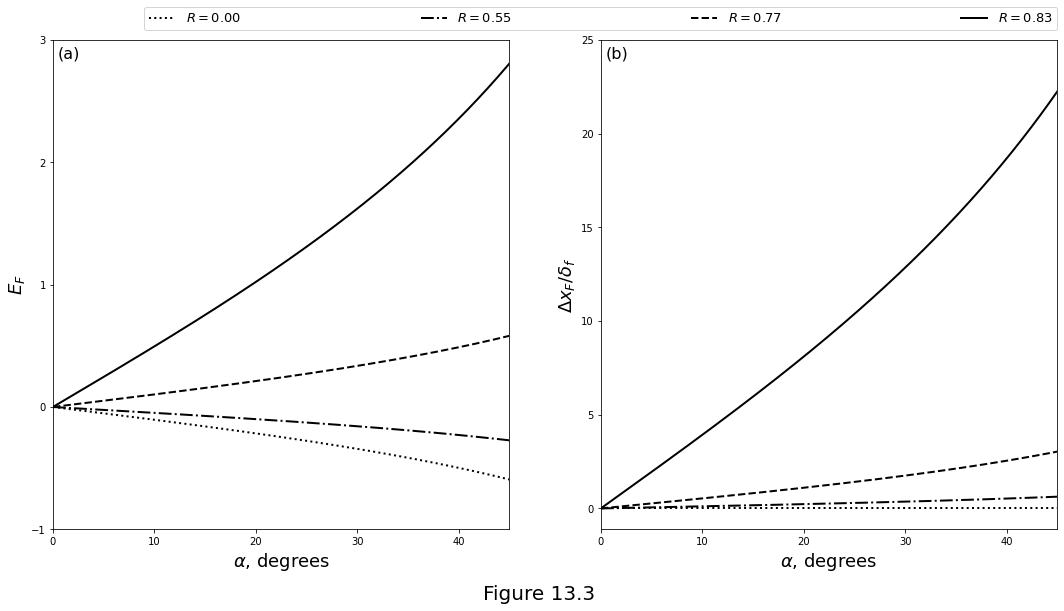

In [5]:
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(18.0, 9.0)

eps = 1.1920929e-07  # extracted from np.finfo(np.float32)
R2 = np.asarray([0.0, 0.3, 0.6, 0.69])
amax = 45.0 * np.pi/180.0
alpha = np.linspace(0.0, amax, 1000)
zeta = np.linspace(-10.0, -eps, 1000)
n = 3
plot_style = [':k', '-.k', '--k', '-k']
plots = []
labels = []

for Rsquared, pltsty in zip(R2, plot_style):
    integ = lambda z: integrand(z, Rsquared)
    ExFlx = quad(integ, -100, 0.0)
    p = ax[0].plot(alpha*180.0/np.pi, np.tan(alpha)*ExFlx[0], pltsty, linewidth=2)
    plots.append(p[0])
    labels.append('$R={:1.2f}$'.format(np.sqrt(Rsquared)))

ax[0].set_xlim(0.0, amax*180/np.pi)
ax[0].set_xticks((0, 10, 20, 30, 40))
ax[0].set_yticks((-1, 0, 1, 2, 3))
ax[0].set_xlabel(r'$\alpha$, degrees', fontsize=18)
ax[0].set_ylabel(r'$E_F$', fontsize=18)
ax[0].text(
    0.5, 2.95, '(a)', fontsize=16, 
    verticalalignment='top', horizontalalignment='left'
)

for Rsquared, pltsty in zip(R2, plot_style):
    integ_dx = lambda z: integrand_Dx(z, Rsquared)
    ExDlx = quad(integ_dx, -100, eps)
    ax[1].plot(
        alpha*180.0/np.pi, np.tan(alpha)*ExDlx[0], pltsty, linewidth=2
    )

ax[1].set_xlim(0.0, amax*180/np.pi)
ax[1].set_xticks((0, 10, 20, 30, 40))
ax[1].set_yticks((0, 5, 10, 15, 20, 25))
ax[1].set_xlabel(r'$\alpha$, degrees', fontsize=18)
ax[1].set_ylabel(r'$\Delta x_F/\delta_f$', fontsize=18)
ax[1].text(
    0.5, 24.7, '(b)', fontsize=16, 
    verticalalignment='top', horizontalalignment='left'
)

plt.legend(
    handles=plots, fontsize=13, labels=labels,
    bbox_to_anchor=(-1.0, 1.02, 2., .2), 
    loc='lower left', ncol=4, mode="expand", borderaxespad=0.
)

fig.supxlabel("Figure 13.3", fontsize=20)

plt.show()

### Lateral transport to a mid-ocean ridge

Figure 13.4 below plots a schematic cross-sectional diagram of the model of mid-ocean ridge melt focusing. The ridge axis is located at $x=0,z=0$. The problem is assumed to have reflection symmetry about the $z$ axis. Dashed lines are temperature contours. The heavy solid line is the outline of the melting region $\meltregion$. A control volume along the top of the melting region is associated with a melting column beneath and a lithospheric strip to the right. The dip of the top of the melting regime is $\infd z_h/\infd x = -\tan\alpha$.

In [6]:
class PAR:

    def __init__(self):

        secperyr = np.pi * 1.e7
        self.Tsfc = 273.                   # K
        self.Tm = 1350. + 273.             # K 
        self.TS0 = 1100. + 273.            # K
        self.clapeyron = 6.5e6             # Pa/K
        self.rho = 3300.                   # kg/m3
        self.kappa = 1e-6                  # m2/sec (thermal diffusivity)
        self.g = 10.                       # m/sec2
        self.x0 = 5000.                    # m
        self.U0 = 4./100./secperyr         # m/sec
        self.zh0 = -10.                    # m
        self.zb = -70.                     # m
        self.Pi = 0.23/(self.zh0-self.zb)  # per m
        self.heatcap = 1200.               # J/kg/K
        self.alpha = 30. * np.pi/180       # radians

        self.clapeyron = self.zb * self.rho * self.g/(self.TS0 - self.Tm)
        self.latent = self.heatcap*self.rho*self.g/self.Pi/self.clapeyron


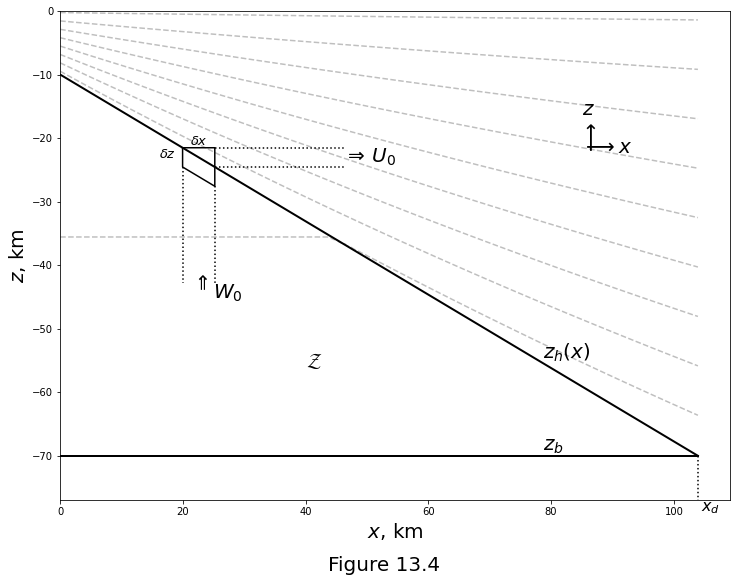

In [7]:
f, ax = plt.subplots()
f.set_size_inches(12.0, 9.0)

p = PAR()
xd = -(p.zb - p.zh0)/np.tan(p.alpha)

x = np.linspace(0.0, xd, 100)
zh = p.zh0 - x * np.tan(p.alpha)
zb = p.zb * np.ones(len(zh))
ax.plot(x, zh, '-k', linewidth=2)
ax.plot(x, zb, '-k', linewidth=2)
ax.set_xlim(0.0, xd*1.05)
ax.set_ylim(p.zb*1.1, 0.0)

ax.plot([xd, xd], [p.zb, p.zb*1.1], ':k')
ax.text(
    1.02*xd, p.zb*1.1, r'$x_d$', 
    verticalalignment='top', horizontalalignment='center', fontsize=16
)
ax.set_xlabel(r'$x$, km', fontsize=20)
ax.set_ylabel(r'$z$, km', fontsize=20)

ax.text(
    x[75], zh[75], r'$z_h(x)$', fontsize=20,
    verticalalignment='bottom', horizontalalignment='left'
)
ax.text(
    x[75], zb[75], r'$z_b$', fontsize=20,
    verticalalignment='bottom', horizontalalignment='left'
)
ax.text(
    40, -55, r'$\mathcal{Z}$', fontsize=20,
    verticalalignment='center', horizontalalignment='left'
)

z = np.linspace(0, p.zb, 400)
T = np.zeros((z.shape[0], x.shape[0]))
for i, zh_i in enumerate(zh):
    Tl = interp1d(
        [0, zh_i], 
        [p.Tsfc, p.TS0 - p.rho*p.g/p.clapeyron*zh_i], 
        fill_value='extrapolate'
    )(z)
    Tm = p.TS0 - p.rho*p.g/p.clapeyron * z
    T[:, i] = Tm * (z < zh_i) + Tl * (z >= zh_i)

cc = ax.contour(
    x, z, T, levels=9, colors='grey', linestyles='--', alpha=0.5
)

x0, x1, x2 = x[20-1], x[25-1], x[45-1]
z0, z1, z2, z3 = zh[20-1], zh[25-1], zh[30-1], zh[55-1]
ax.plot([x0, x1, x1, x0, x0], [z0, z0, z2, z1, z0], '-k')
ax.plot([x0, x0],[z1, z3], ':k')
ax.plot([x1, x1],[z2, z3], ':k')
ax.plot([x1, x2],[z0, z0], ':k')
ax.plot([x1, x2],[z1, z1], ':k')

ax.text(
    85, -20, r'$\longrightarrow x$', fontsize=20,
    verticalalignment='top', horizontalalignment='left'
)
ax.text(
    85, -20, r'$\longrightarrow$', fontsize=20, rotation=90,
    verticalalignment='center', horizontalalignment='left'
)
ax.text(
    85, -14, r'$z$', fontsize=20,
    verticalalignment='top', horizontalalignment='left'
)
ax.text(
    x2, (z1+z0)/2, r'$\Rightarrow\,U_0$', 
    verticalalignment='center', fontsize=20
)
ax.text(
    1.1*(x0+x1)/2, z3, r'$\Rightarrow$', rotation=90, fontsize=20,
    verticalalignment='center', horizontalalignment='right',
)
ax.text(
    1.1*(x0+x1)/2, z3, r'$W_0$', fontsize=20,
    verticalalignment='top', horizontalalignment='left'
)
ax.text(
    x0-1, z0, r'$\delta z$', fontsize=13,
    verticalalignment='top', horizontalalignment='right'
)
ax.text(
    (x0+x1)/2, z0, r'$\delta x$', fontsize=13,
    verticalalignment='bottom', horizontalalignment='center'
)

f.supxlabel("Figure 13.4", fontsize=20)

plt.show()

The freezing rate is evaluated as

$$
\begin{equation}
  \label{eq:mor-decomp-energycon}
  G = \frac{\kappa\heatcapacity}{\latent}\left(\left.\diff{\temp}{z}
    \right\vert_{z_h^+} - \left.\diff{\temp}{z}\right\vert_{z_h^-}\right).
\end{equation}
$$

The crustal thickness is given by $-q/U_0$. $q$ is the volumetric flow rate along the channel, and satisfies

$$
\begin{equation}
  \label{eq:mor-decomp-flux-divergence}
  \diff{q}{x} = \frac{G - U_0\diff{z_h}{x} F(z_h)}{1-F(z_h)}.
\end{equation}
$$

Figure 13.5 below plot results of the mid-ocean ridge focusing model with reference parameters. __(a)__ The freezing rate $-G$. __(b)__ The equivalent crustal thickness $-q/U_0$. Parameter values used here are $\soltemp_0=1373$, $T_m=1623$ K, $z_b=-70$ km, $z_{h0} = -10$ km, $z_h = z_{h0} - x\tan\alpha$, $\alpha=30^\circ$ (giving $x_d=104$~km), $F_\text{max}=0.23$, $\Pi=F_\text{max}/(z_h(0) - z_b)$, $\clapeyron = z_b\density g/(\soltemp_0 - T_m)$, $\latent = \heatcapacity\density g/\clapeyron\Pi$, and other paramters as in Table (8.1).

In [8]:
def FocusingModelTriangle(par=None):

    secperyr = 60*60*24*365.5

    if par is None:
        par = PAR()
        par.Tsfc = 273.
        par.Tm = 1350. + 273.
        par.TS0 = 1100. + 273.
        par.zh0 = - 10*1e3
        par.zb = -70*1e3
        par.Pi = 0.23/(par.zh0 - par.zb)
        par.rho = 3300
        par.kappa = 1e-6
        par.heatcap = 1200
        par.g = 10
        par.alpha = 30*np.pi/180.
        par.U0 = 4./100./secperyr
        
    # thermodynamic parameters from constraints
    par.clapeyron = par.zb * par.rho * par.g/(par.TS0 - par.Tm)
    par.latent = par.heatcap * par.rho * par.g / par.Pi / par.clapeyron
    
    # channel position
    x = np.linspace(0, (par.zh0 - par.zb)/np.tan(par.alpha), 8000)
    zh = par.zh0 - x * np.tan(par.alpha)
    F = par.Pi * (zh - par.zb)

    # freezing rate
    Tzh = par.TS0 - par.rho * par.g * zh / par.clapeyron
    G = par.kappa * par.heatcap / par.latent * (
        Tzh/zh + par.rho *par.g / par.clapeyron
    )
   
    # flux divergence
    dqdx = (G + par.U0 * np.tan(par.alpha) * F)/(1 - F)
    q = cumtrapz(dqdx, x, initial=0)
    q = q - max(q)
    I = np.argmax(q == 0.0)
    q[I:] = np.nan
    
    par.x = x / 1e3
    par.zh = zh / 1e3
    par.cruth = -q / par.U0 / 1e3
    par.G = G * secperyr
    par.xd = -(par.zb - par.zh0) / np.tan(par.alpha) / 1e3
    par.alpha_crit = np.arctan(-G * (1-F) / par.U0 / F)

    return par

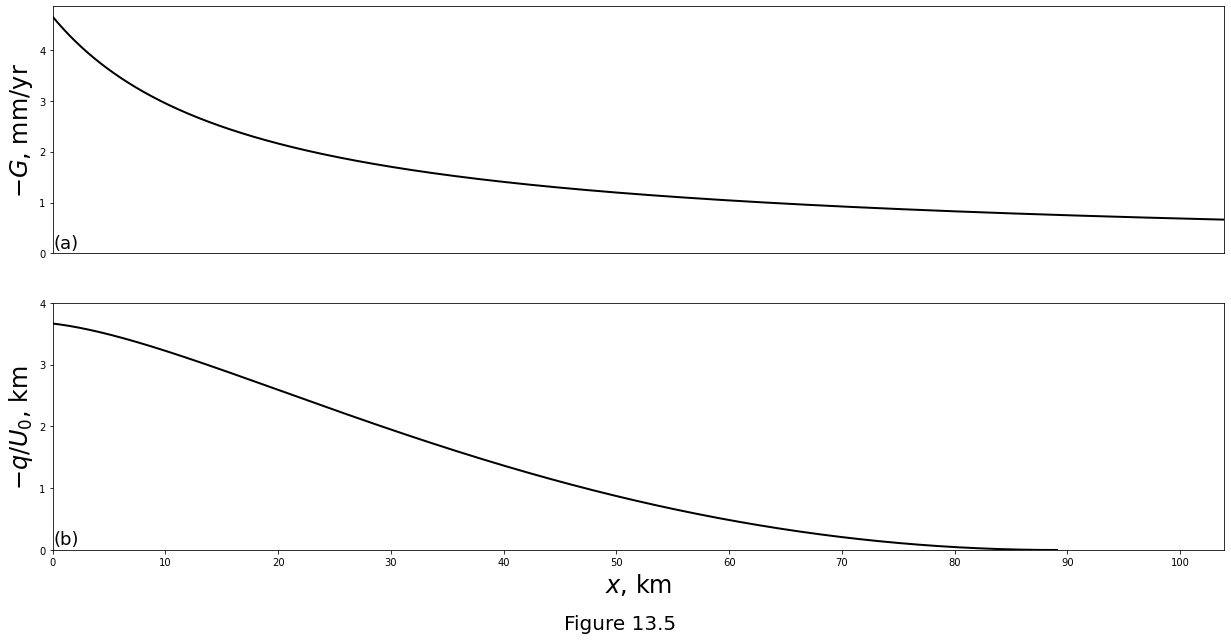

In [9]:
f, ax = plt.subplots(2, 1)
f.set_size_inches(21.0, 10.0)

A = FocusingModelTriangle()

ax[0].plot(A.x, -A.G * 1e3, '-k', linewidth=2)
ax[0].set_ylabel(r'$-G$, mm/yr', fontsize=24)
ax[0].set_xticks(())
ax[0].set_xlim(0.0, A.xd)
ax[0].set_yticks((0, 1, 2, 3, 4))
ax[0].text(0.1, 0.1, r'(a)', fontsize=18)

ax[1].plot(A.x, A.cruth, '-k', linewidth=2)
ax[1].set_ylabel(r'$-q/U_0$, km', fontsize=24)
ax[1].set_xlabel(r'$x$, km', fontsize=24)
ax[1].set_xlim(0.0, A.xd)
ax[1].set_ylim(0.0, 4.0)
ax[1].set_xticks(np.arange(0, 101, 10))
ax[1].set_yticks((0, 1, 2, 3, 4))
ax[1].text(0.1, 0.1, r'(b)', fontsize=18)

f.supxlabel("Figure 13.5", fontsize=20)

plt.show()

Figure 13.6 below shows how the solution to $\eqref{eq:mor-decomp-flux-divergence}$ varies with the dip of the focusing boundary $\alpha = \tan^{-1}(-\infd z_h/\infd x)$ and the spreading rate $U_0$. __(a)__ holding $U_0$ fixed, a larger dip leads to a thicker crust ($-q(0)/U_0$). __(b)__ for
fixed $\alpha$, larger spreading rate also leads to a thicker crust. In both cases, this is because $W_0$ is increased, causing more rapid melting and a greater melt flux from the melting columns to the decompaction channel. __(c)__ shows that faster spreading (with associated reduction in $\alpha$) leads to a thicker crust. The models predicts that this effect does not saturate with increasing spreading rate. This is inconsistent with observations of crustal thickness as a function of spreading rate, which saturates at a half-rate of 2 cm/year to a thickness of about 7 km.

Text(0.5, 0.01, 'Figure 13.6')

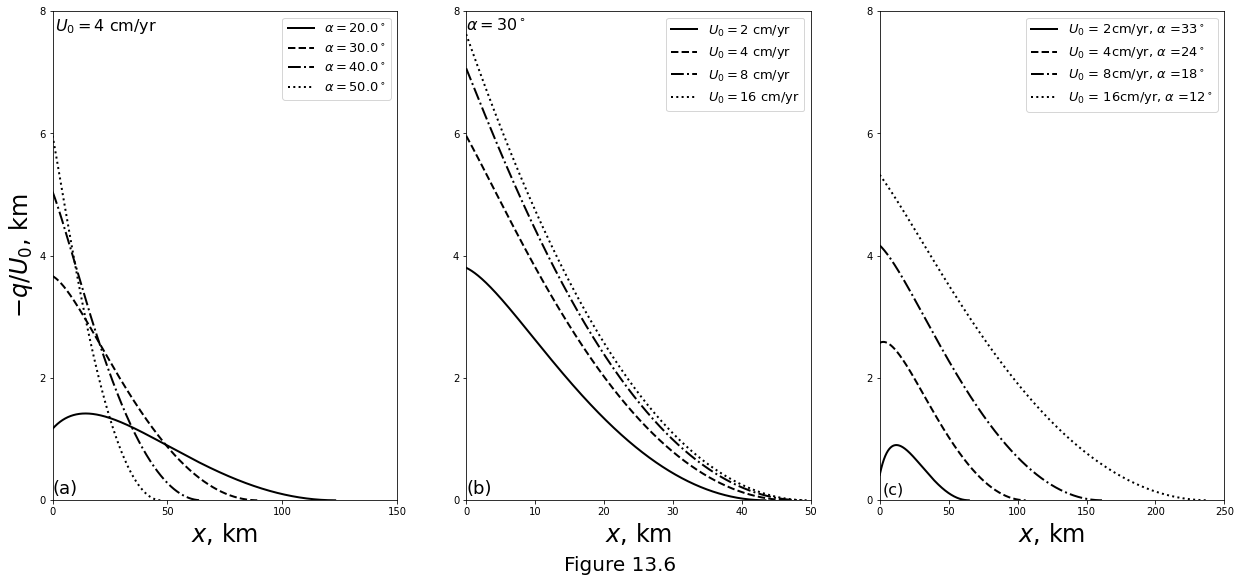

In [10]:
f, ax = plt.subplots(1, 3)
f.set_size_inches(15.0, 9.0)

par = FocusingModelTriangle()

alpha = np.array([20., 30., 40., 50.]) * np.pi/180.
pltstl = ['-k', '--k', '-.k', 'k:']

for a, stl in zip(alpha, pltstl):
    par.alpha = a
    A = FocusingModelTriangle(par);
    ax[0].plot(
        A.x, A.cruth, stl, linewidth=2, 
        label=r'$\alpha ='+str(np.ceil(a*180/np.pi))+'^\circ$'
    )

ax[0].set_xlabel(r'$x$, km', fontsize=24)
ax[0].set_ylabel(r'$-q/U_0$, km', fontsize=24)
ax[0].set_xlim(0.0, 150)
ax[0].set_xticks((0, 50, 100, 150))
ax[0].set_yticks((0, 2, 4, 6, 8))
ax[0].set_ylim(0.0, 8.0)
ax[0].text(
    0.99, 7.9, r'$U_0 = 4$ cm/yr', fontsize=16, 
    verticalalignment='top', horizontalalignment='left'
)
ax[0].text(0.1, 0.1, '(a)', fontsize=18)
ax[0].legend(fontsize=13)

secperyr = 60. * 60. * 24. * 365.5
U0 = np.array([2., 4., 8., 16.])/100/secperyr  # m/sec
for u0, stl in zip(U0, pltstl):
    par.U0 = u0
    A = FocusingModelTriangle(par)
    ax[1].plot(
        A.x, A.cruth, stl, linewidth=2, 
        label=r'$U_0 ='+str(int(u0*100.*secperyr))+'$ cm/yr'
    )
ax[1].set_xlabel(r'$x$, km', fontsize=24)
ax[1].set_xlim(0.0, 50.0)
ax[1].set_ylim(0.0, 8.0)
ax[1].set_yticks((0, 2, 4, 6, 8))
ax[1].text(0.1, 0.1, r'(b)', fontsize=18)
ax[1].text(
    0.05, 7.9, r'$\alpha=30^\circ$', fontsize=16, 
    verticalalignment='top', horizontalalignment='left'
)
ax[1].legend(fontsize=13)

secperyr = 60*60*24*365.5;
C = 2.32  # prefactor in lithospheric thickness
K = 1e-6  # diffusivity, m^2/sec
U0 = np.array([2., 4., 8., 16.])/100./secperyr  # m/sec
x_alpha = 5.  # km
for u0, stl in zip(U0, pltstl):
    yL  = C * np.sqrt(K * (x_alpha * 1e3)/u0)  # lithospheric thickness, m
    yLp = C * C * K / 2. / u0 / yL;            # lithospheric slope
    par.alpha = np.arctan(yLp)                 # local angle of the LAB, degrees
    par.U0 = u0
    A = FocusingModelTriangle(par)
    plt.plot(
        A.x, A.cruth, stl, linewidth=2,
        label=r'$U_0$ = ' + str(int(u0*100*secperyr)) 
            + r'cm/yr, $\alpha$ =' 
            + str(int(par.alpha*180/np.pi)) + r'$^\circ$'
    )
ax[2].set_xlim(0.0, 250.0)
ax[2].set_ylim(0.0, 8.0)
ax[2].set_yticks((0, 2, 4, 6, 8))
ax[2].set_xlabel(r'$x$, km', fontsize=24)
ax[2].text(
    2.0, 0.3, r'(c)', fontsize=16, 
    verticalalignment='top', horizontalalignment='left'
)
ax[2].legend(fontsize=13);

f.supxlabel("Figure 13.6", fontsize=20);